<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/pressure_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pressure control implementations


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
This notebook reviews pressure control implementations in water distribution networks. We present operational data for the following pressure control schemes
- Fixed outlet
- Time-based
- Flow modulation

We also implement code to derive a flow modulation curve from operational data. Finally, a model-based optimal control problem is formulated and solved using a state-of-the art nonlinear solver. The problem formulation relies on the steady-state hydraulic conservation laws introduced earlier in this module.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [1]:
# Run this cell once
# %%capture
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install wntr
  !apt-get install libsuitesparse-dev && pip install scikit-sparse
  !pip install -q pyomo
  !pip install --upgrade idaes-pse
  !idaes get-extensions --to ./bin
  os.environ['PATH'] += ':bin'

Cloning into 'CIVE_70019_70057'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 335 (delta 79), reused 50 (delta 19), pack-reused 190
Receiving objects: 100% (335/335), 3.27 MiB | 12.58 MiB/s, done.
Resolving deltas: 100% (167/167), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 13.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libsliplu1 libspqr2 libsuitesparseconfig5 libumfpack5
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libslipl

In [2]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

### Load and visualise operational data

Three 'data.npy' files are provided in the module repository's data directory.

In [3]:
# Load operational data
data_dir = '/content/CIVE_70019_70057/data/pressure_control/'
data_name = 'data_1.npy' # data_1.npy; data_2.npy; data_3.npy

data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()

Code to visualise operational data.

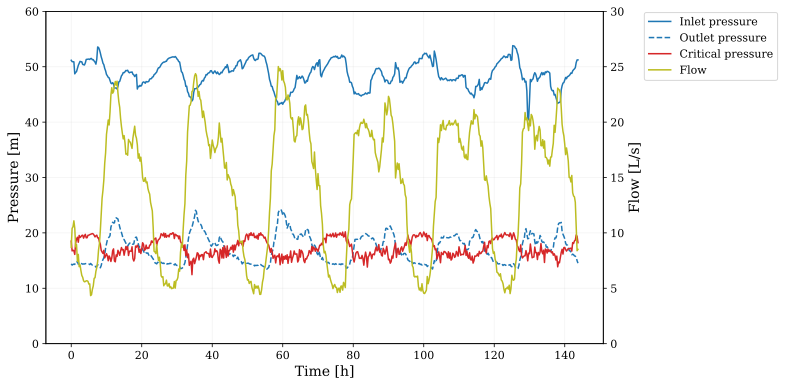

In [4]:
# Make time data
time = [num / 4 for num in range(len(data['p_in']))]

# Font style
plt.rcParams["font.family"] = "serif"

# Create a figure and plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot pressure on the primary y-axis
plt1 = ax1.plot(time, data['p_in'], '-', color='tab:blue')
plt2 = ax1.plot(time, data['p_out'], '--', color='tab:blue')
plt3 = ax1.plot(time, data['p_critical'], '-', color='tab:red')

ax1.set_ylim([0, 60])
ax1.set_ylabel('Pressure [m]', fontsize=14)
ax1.set_xlabel('Time [h]', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.grid(alpha=0.15)

# Plot flow on the secondary y-axis
ax2 = ax1.twinx()
plt4 = ax2.plot(time, data['flow'], '-', color='tab:olive')
ax2.set_ylim([0, 30])
ax2.set_ylabel('Flow [L/s]', fontsize=14)
ax2.tick_params(axis='y', which='major', labelsize=11)

# Legend code
fig.legend([plt1, plt2, plt3, plt4], labels=['Inlet pressure', 'Outlet pressure', 'Critical pressure', 'Flow'], bbox_to_anchor=(1.15, 0.89), fontsize=11)

Try plotting each data set and commenting on the corresponding pressure control scheme (e.g. no control, fixed outlet, time-based, or flow modulation). What observations led you to these conclusions?

Enter responses below:
*   List item
*   List item
*   List item



### Flow modulation curve

Load and organise operational data.

In [5]:
# Load operational data (use data_1.npy)
data_dir = '/content/CIVE_70019_70057/data/pressure_control/'
data_name = 'data_1.npy'

data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()

# Assign variables
inlet_pressure = data['p_in']
outlet_pressure = data['p_out']
critical_pressure = data['p_critical']
flow = data['flow']
outlet_elev = data['outlet_elev']
critical_elev = data['critical_elev']

Compute head loss across simplified 'single pipe' system from the pressure
control valve (PCV) outlet to the critical point (CP), as follows


\begin{equation}
  h_f = (p_{\text{out}} + \zeta_{\text{out}}) - (p_{\text{crit}} + \zeta_{\text{crit}}),
\end{equation}

where $p$ is the pressure head and $\zeta$ is the elevation head.

In [6]:
# Offset minimum regulatory pressure head (e.g. 15 m) and elevation difference
hf = (outlet_pressure + outlet_elev) - (critical_pressure + critical_elev)

Plot head loss - flow relationship.

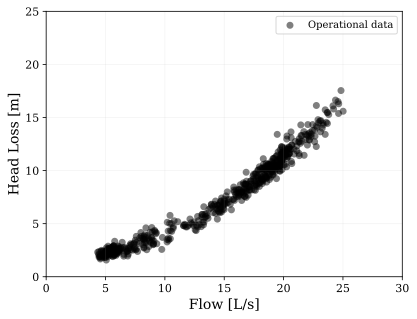

In [7]:
# Plotting code
plt.figure()

plt.scatter(flow, hf, marker='o', label='Operational data', s=50, alpha=0.5, edgecolor='none', facecolor='black')
plt.xlabel('Flow [L/s]', fontsize=14)
plt.ylabel('Head Loss [m]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.xlim([0, 30])
plt.ylim([0, 25])
plt.grid(alpha=0.15)
plt.legend()

Derive flow modulation control curve.

In [8]:
# Offset minimum regulatory pressure (e.g., 15 m) and elevation difference
outlet_control = hf + 15 + (critical_elev - outlet_elev)

# Reshape them to 1D arrays
flow = flow.ravel()
outlet_control = outlet_control.ravel()

# Polynomial curve fitting
coeff = np.polyfit(flow, outlet_control, 2)

# Generate a curve using the fitted coefficients
flow_min = min(flow)
flow_max = max(flow)
fm_curve_size = int((round(flow_max) + 10) * 4 + 1) # additional step for lower bound
fm_curve_step = (round(flow_max) + 10) / fm_curve_size
x = np.arange(0, fm_curve_size) * fm_curve_step

fm_curve = np.zeros((len(x), 2))
fm_curve[:, 0] = x
fm_curve[:, 1] = np.polyval(coeff, x)

# Set lower bound outlet pressure
fm_curve[0, 1] = 35
fm_curve[1, 0] = 0

Plot flow modulation curve.

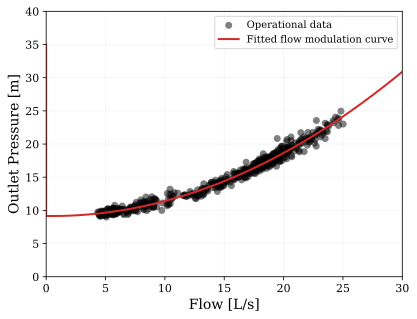

In [9]:
# Plotting code
plt.figure()

plt.scatter(flow, outlet_control, marker='o', s=50, alpha=0.5, edgecolor='none', facecolor='black')
plt.plot(fm_curve[:, 0], fm_curve[:, 1], '-', color='tab:red', linewidth=2)
plt.xlabel('Flow [L/s]', fontsize=14)
plt.ylabel('Outlet Pressure [m]', fontsize=14)
plt.xlim([0, 30])
plt.ylim([0, 40])
plt.grid(alpha=0.15)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.legend(['Operational data', 'Fitted flow modulation curve'])

#### Interpretation of flow modulation curve

Prompts for discussion on the derived flow modulation curve:


*   What causes the general curvature in the control profile? Would you expect this to be different for different network conditions?
*   Should there be any concern with the derived outlet pressures being below the regulatory minimum of 15 m? Why or why not?
*   What may the general reasoning be behind the lower bound pressure outlet value? Is this necessary?

### Model-based optimal pressure control

In this section, we introduce an optimisation problem to compute valve settings for minimising pressure. In particular, we seek to minimise the average zone pressure (AZP) of the network. The following code walks through the problem formulation and implementation of the open-source solver IPOPT to solve the nonlinear optimisation problem.

**Reference**: Wright, R., Abraham, E., Parpas, P., Stoianov, I. (2015). 'Control of water distribution networks with dynamic dma topology using strictly feasible sequential convex programming.' Water Resources Research 51(12), 9925–9941, doi: 10.1002/2015WR017466.

#### AZP objective function:

\begin{equation*}
  \text{AZP}(x) := \frac{1}{n_t} \sum_{t=1}^{n_t} \sum_{i=1}^{n_n} w_i (h_{it} - \zeta_i),
\end{equation*}

where $h_{it}$ is the hydraulic head computed at node $i$ at time step $t$; $\zeta_i$ is the elevation of node $i$; and $w_i$ is a coefficient weighting node $i$ by the length of its connected links. That is,

\begin{equation}
        w_i = \bar{L}^{-1} \sum_{k \in \mathcal{I}_i} \frac{L_i}{2},
\end{equation}

where $\mathcal{I}_i$ is the set of links incident to node $i$; $\bar{L} = \sum_{j=1}^{n_p} L_j$; and $L \in \mathbb{R}^{n_p}$ is the vector of pipe lengths. As described in the hydraulic modelling notebook, $n_n$, $n_p$, and $n_t$ denote the number of model nodes, links, and hydraulic time steps, respectively.

#### Hydraulic constraints

Optimal valve settings for minimising of AZP must be hydraulically feasible. That is, hydraulic states of **flow** across links and **hydraulic head** at nodes must statisfy the energy and mass conservation equations introduced previously. We make one modification to the energy conservation equation to account for additional local losses across pressure control valves (PCVs). This term, $\eta$, is a decision variable in our optimisation problem. The energy and mass conservation equations are then written as, for all time steps $t \in \{1, \dots, n_t\}$

\begin{equation}
    A_{11}(q_t)q_t + A_{12}h_t + A_{10}h_{0t} + A_{13}\eta_t = 0 \\
    A_{12}^{T}q_t + d_t = 0,
\end{equation}

where
- $q_t \in \mathbb{R}^{n_p}$ is a vector of link flows
- $h_t \in \mathbb{R}^{n_n}$ is a vector of nodal heads
- $\eta_t \in \mathbb{R}^{n_v}$ is a vector of local losses across PCV links
- $A_{11} \in \mathbb{R}^{n_p \times n_p} = k_j|q_j^{n-1}|, \;\, \forall j \in \{1, \dots, n_p\}$ is a diagonal matrix of frictional head losses and $k_j$ is the pipe or valve resistance coefficient
- $A_{12} \in \mathbb{R}^{n_p \times n_n}$ is the link-node incidence matrix
- $A_{10} \in \mathbb{R}^{n_p \times n_0}$ is the link-known head incidence matrix
- $A_{13} \in \mathbb{R}^{n_p \times n_v}$ maps PCV locations which permit a local loss $\eta_t$
- $d_t \in \mathbb{R}^{n_n}$ is a vector of known demands (i.e. loading conditions)
- $h_{0t} \in \mathbb{R}^{n_0}$ is a vector of known hydraulic heads (i.e. boundary conditions)
- $\zeta \in \mathbb{R}^{n_n}$ is the vector of nodal elevations

In addition, we enforce bounds on continuous state and control variables. The first is a minimum hydraulic head constraint

\begin{equation*}
  h_t \geq h^{\min}, \quad \forall t \in \{1, \dots, n_t\}
\end{equation*}

where $h^{\min} \in \mathbb{R}^{n_n}$ corresponds to a minimum regulatory pressure (e.g. 15 m) + elevation head $\zeta$.

The other bound is on the direction of flow $q_t$ and $\eta_t$ at each time step $t$. In this problem, we the known PCV link is defined in the positive flow direction. Therefore,

\begin{alignat}{3}
  &A_{13}^Tq_t \geq 0, \quad \forall t \in \{1, \dots, n_t\} \\
  &\eta_t \geq 0, \quad \forall t \in \{1, \dots, n_t\}
\end{alignat}

#### Problem formulation

We denote the continuous decision variables in our AZP optimisation problem as $x_t := [q_t^T, h_t^T, \eta_t^T]^T$, for all $t \in \{1, \dots, n_t\}$. The AZP optimisation problem is formulated as

\begin{alignat}{3}
  & \underset{\substack{x}}{\text{minimize}}
  & \quad & \frac{1}{n_t} \sum_{t=1}^{n_t} \sum_{i=1}^{n_n} w_i (h_{it} - \zeta_i) \\
  & \text{subject to}
  & & A_{11}(q_t)q_t + A_{12}h_t + A_{10}h_{0t} + A_{13}\eta_t = 0, \quad \forall t \in \{1,\dots,n_t\} \\
  & & & A_{12}^{T}q_t + d_t = 0, \quad \forall t \in \{1,\dots,n_t\} \\
  & & & x_t \in X_t, \quad \forall t \in \{1,\dots,n_t\}
\end{alignat}

where set $\mathcal{X}$ collects the previously defined bounds on continuous variables.

#### Code implementation

Import previously defined functions in hydraulic modelling notebook.

In [10]:
%cd '/content/CIVE_70019_70057/src/'
import general_functions as gen_fn
import hydraulic_functions as hyd_fn
%cd '/content/'

/content/CIVE_70019_70057/src
/content


Load network data.

In [11]:
# Network data
net_name = 'stkl.inp'
net_dir = '/content/CIVE_70019_70057/data/networks/'

wdn = gen_fn.load_network_data(os.path.join(net_dir, net_name))

Set PCV link location.

In [12]:
# PCV link name(s) (do not change)
pcv_name = ['link_1837']

# Extract element names
pipe_names = wdn.net_info['pipe_names']
junction_names = wdn.net_info['junction_names']

# Find indices of pcv_links and corresponding downstream nodes
pcv_loc = [i for i, name in enumerate(pipe_names) if name in pcv_name]
pcv_nodes = wdn.link_df.loc[pcv_loc, 'node_in'].tolist()

Plot network.

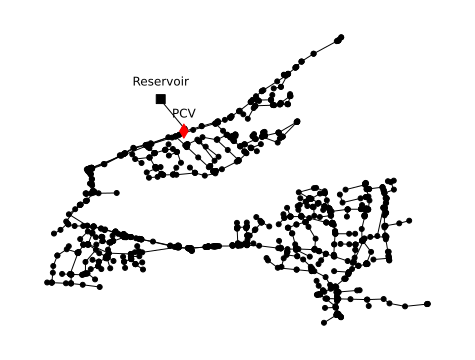

In [13]:
gen_fn.plot_network(wdn, pcv_nodes=pcv_nodes)

Create optimisation problem parameters.

In [105]:
from scipy.sparse import csr_matrix

# Unload variables
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df
h0_df = wdn.h0_df

L = link_df['length'].values.astype(float).reshape(-1, 1)
elev = node_df.loc[node_df['node_ID'] != '1', 'elev'].astype(float).to_numpy().reshape(-1, 1)
d = demand_df.iloc[:, 1:].astype(float).to_numpy()
h0 = h0_df.iloc[:, 1:].astype(float).to_numpy()

# Make A13 matrix (pcv mapping)
A13 = np.zeros([net_info['np'], len(pcv_loc)])
for idx, loc in enumerate(pcv_loc):
    A13[loc, idx] = 1
A13 = csr_matrix(A13)

# Initial continuous variables
q_df, h_df = hyd_fn.hydraulic_solver(wdn, method='nr_schur') # no control hydraulics
q_0 = q_df.iloc[:, 1:].to_numpy()
h_0 = h_df.iloc[:, 1:].to_numpy()

eta_0 = np.zeros([len(pcv_loc), net_info['nt']])

# AZP weights (w)
w = np.abs(A12.T) * np.array(L) / 2
azp_weights = w / np.sum(w)

# h and q variable bounds
pmin = 15 # 15 m minimum pressure head
h_min = pmin + elev * np.ones([1, net_info['nt']])
h_max = np.ones([net_info['nn'], 1]) * np.max(h0, axis=0)

q_min = np.ones([net_info['np'], net_info['nt']]) * -np.inf
q_max = np.ones([net_info['np'], net_info['nt']]) * np.inf

# eta variable bounds
A = np.hstack([A12.toarray(), A10.toarray()])
all_h_min = np.vstack([h_min, h0])
all_h_max = np.vstack([h_max, h0])

eta_min = np.zeros([net_info['np'], net_info['nt']])
eta_max = np.zeros([net_info['np'], net_info['nt']])

for link in range(net_info['np']):
    out_node = np.where(A[link, :] == -1)[0]
    in_node = np.where(A[link, :] == 1)[0]

    eta_min[link, :] = all_h_min[out_node[0], :] - all_h_max[in_node[0], :]
    eta_max[link, :] = all_h_max[out_node[0], :] - all_h_min[in_node[0], :]

eta_min = eta_min[pcv_loc, :]
eta_max = eta_max[pcv_loc, :]

# Enforce q and eta bounds at PCV links
q_min[pcv_loc, :] = 0
eta_min[:] = 0

In [35]:
q_test = q_0[:, 1]
A13.T @ q_test

array([0.01])

Formulate Pyomo model.

In [16]:
from pyomo.environ import *

##### EXAMPLE MODEL #####

# create a model
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(expr = 40*model.x + 30*model.y, sense=maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

model.pprint()

def display_solution(model):

    # display solution
    print('\nProfit = ', model.profit())

    print('\nDecision Variables')
    print('x = ', model.x.value)
    print('y = ', model.y())

    print('\nConstraints')
    print('Demand  = ', model.demand())
    print('Labor A = ', model.laborA())
    print('Labor B = ', model.laborB())

SolverFactory('ipopt').solve(model, tee=True).write()
display_solution(model)

2 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    profit : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 40*x + 30*y

3 Constraint Declarations
    demand : Size=1, Index=None, Active=True
        Key  : Lower : Body : Upper : Active
        None :  -Inf :    x :  40.0 :   True
    laborA : Size=1, Index=None, Active=True
        Key  : Lower : Body  : Upper : Active
        None :  -Inf : x + y :  80.0 :   True
    laborB : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :  -Inf : 2*x + y : 100.0 :   True

6 Declarations: x y profit demand laborA laborB
Ipopt 